In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense

In [18]:
data = pd.read_csv('/Users/annabelholmes1101/Desktop/block/merged_data.csv')
data

,ts_event,bid_fill,ask_fill,Signed Volume,price,best_bid,best_ask,mid_price
0,2024-10-22 08:00:00,801.0,1999.0,-1198.0,236.14,235.83,236.14,235.985
1,2024-10-22 08:00:01,201.0,202.0,-1.0,236.13,235.83,236.13,235.980
2,2024-10-22 08:00:02,1600.0,1400.0,200.0,235.83,235.83,236.11,235.970
3,2024-10-22 08:00:03,534.0,400.0,134.0,236.10,235.96,236.10,236.030
4,2024-10-22 08:00:04,400.0,502.0,-102.0,236.11,235.96,236.11,236.035
...,...,...,...,...,...,...,...,...
27702,2024-10-22 23:58:59,32.0,0.0,32.0,235.54,235.54,235.81,235.675
27703,2024-10-22 23:59:00,40.0,40.0,0.0,235.54,235.23,235.81,235.520
27704,2024-10-22 23:59:37,0.0,1.0,-1.0,235.70,235.23,235.70,235.465
27705,2024-10-22 23:59:41,5.0,0.0,5.0,235.60,235.60,235.70,235.650


### Construct and code the linear OW model and nonlinear AFS model and visualize the distribution of price impact based on the given data

In [ ]:
def kernel_matrix(timestamps, beta):
    time_diff = timestamps[:, None] - timestamps[None, :]
    kernel = np.exp(-beta * np.clip(time_diff, a_min=0, a_max=None))  # t >= s
    return kernel

def compute_J_t(signed_volume, kernel_matrix):
    upper_triangular_K = np.triu(kernel_matrix)
    J_t = upper_triangular_K @ signed_volume
    return J_t

def compute_I_t(J_t, lambda_value):
    I_t = []
    cumulative_J_t = 0
    for t in range(len(J_t)):
        cumulative_J_t += J_t[t]
        I_t.append(lambda_value * cumulative_J_t)
    return np.array(I_t)

def nonlinear_impact(J_t, p):
    return np.sign(J_t) * np.abs(J_t) ** p

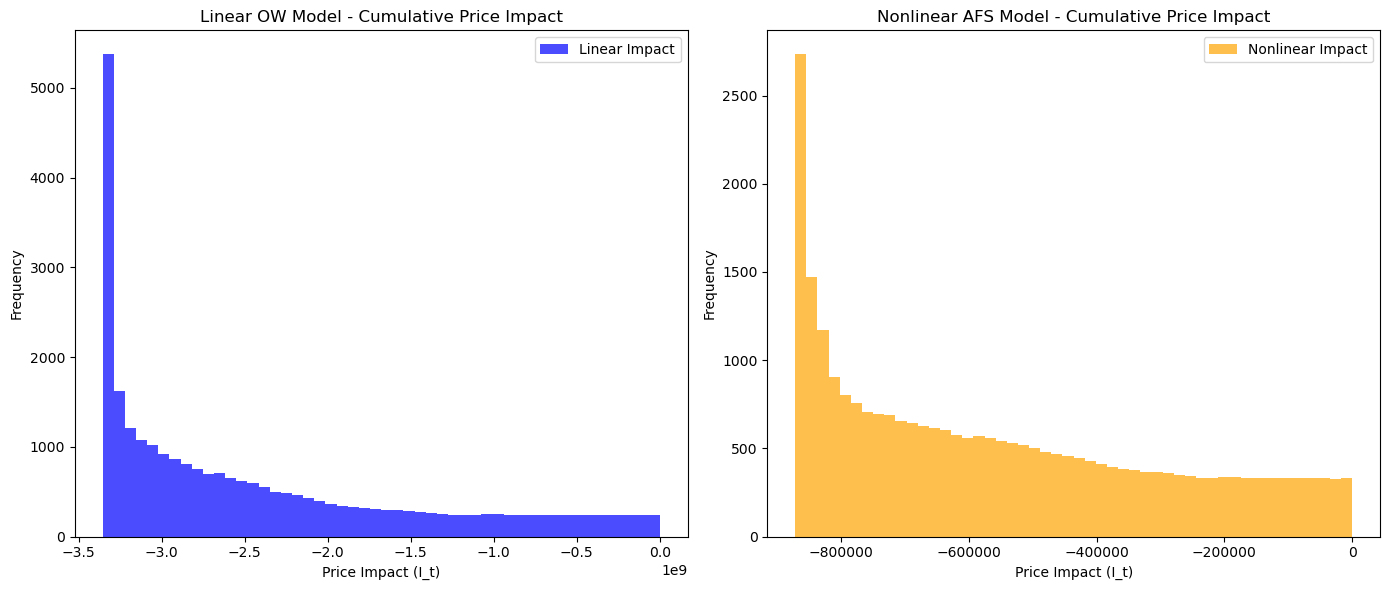

In [4]:
'''linear OW model'''
df = data.copy()

timestamps = np.array(df.index)
signed_volume = np.array(df['Signed Volume'])
beta = 0.5 
kernel = kernel_matrix(timestamps, beta) # K
J_t = compute_J_t(signed_volume, kernel) # J_t
lambda_value = 0.01

# Linear Model
I_t_linear = compute_I_t(J_t, lambda_value)

# Nonlinear Model
p = 0.5
I_t_nonlinear = compute_I_t(nonlinear_impact(J_t, p), lambda_value)

# plot
plt.figure(figsize=(14, 6))

# Linear Impact
plt.subplot(1, 2, 1)
plt.hist(I_t_linear, bins=50, color="blue", alpha=0.7, label="Linear Impact")
plt.title("Linear OW Model - Cumulative Price Impact")
plt.xlabel("Price Impact (I_t)")
plt.ylabel("Frequency")
plt.legend()

# Nonlinear Impact
plt.subplot(1, 2, 2)
plt.hist(I_t_nonlinear, bins=50, color="orange", alpha=0.7, label="Nonlinear Impact")
plt.title("Nonlinear AFS Model - Cumulative Price Impact")
plt.xlabel("Price Impact (I_t)")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


### Implement and code the optimal strategy with Linear Impact and visualize the Sharpe Ratio plots in Section 6.2

In [5]:
# P&L, R
def calculate_pnl_and_risk(signed_volume, f, timestamps, beta, lambda_value, DR, dt):
   
    # Kernel
    K = kernel_matrix(timestamps, beta)
    # J_t
    J_t = compute_J_t(signed_volume, K)
    # Q_t
    Q = np.cumsum(signed_volume)
    # Q_t * f_t
    pnl_first_term = np.sum(Q * f * dt)
    # lambda * J_t^2
    pnl_second_term = lambda_value * np.sum(J_t ** 2 * dt)  
    # total P&L
    P = pnl_first_term - pnl_second_term

    # risk
    R = np.var(J_t ** 2) * DR
    
    return P, R

# Sharpe Ratio
def compute_sharpe_ratio(pnl, risk):
    return pnl / np.sqrt(risk) if risk > 0 else 0

# Sharpe Ratio vs beta +  Sharpe Ratio vs lambda
def plot_sharpe_ratios(signed_volume, f, timestamps, beta_values, lambda_values, DR_levels, dt):
    plt.figure(figsize=(12, 6))

    for DR in DR_levels:
        sharpe_ratios_beta = []
        sharpe_ratios_lambda = []

        # Sharpe Ratio vs beta (fixed lambda)
        fixed_lambda = 0.02
        for beta in beta_values:
            pnl, risk = calculate_pnl_and_risk(signed_volume, f, timestamps, beta, fixed_lambda, DR, dt)
            sharpe_ratios_beta.append(compute_sharpe_ratio(pnl, risk))

        # Sharpe Ratio vs lambda (fixed beta)
        fixed_beta = 5.0
        for lambda_value in lambda_values:
            pnl, risk = calculate_pnl_and_risk(signed_volume, f, timestamps, fixed_beta, lambda_value, DR, dt)
            sharpe_ratios_lambda.append(compute_sharpe_ratio(pnl, risk))

        # Plot for 'Sharpe Ratio vs beta'
        plt.subplot(1, 2, 1)
        plt.plot(beta_values, sharpe_ratios_beta, label=f"DR = {DR}M")
        plt.title("Sharpe Ratio vs Beta")
        plt.xlabel("Beta (Impact Decay)")
        plt.ylabel("Sharpe Ratio")
        plt.legend(loc='best')

        # Plot for 'Sharpe Ratio vs lambda'
        plt.subplot(1, 2, 2)
        plt.plot(lambda_values, sharpe_ratios_lambda, label=f"DR = {DR}M")
        plt.title("Sharpe Ratio vs Lambda")
        plt.xlabel("Lambda (Impact Level)")
        plt.ylabel("Sharpe Ratio")
        plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

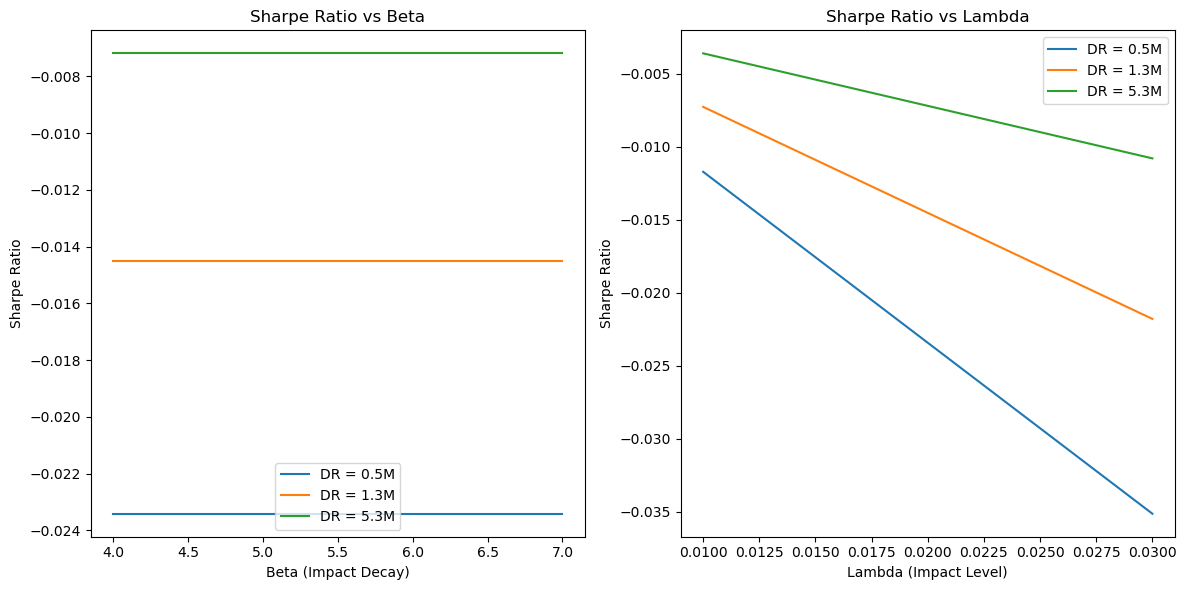

In [44]:
df = data.copy()
timestamps = np.array(df.index)
signed_volume = np.array(df['Signed Volume'])
dt = 1/len(timestamps)

f = np.array((df['mid_price']/df['mid_price'].shift(1)-1).fillna(0))

beta_values = np.linspace(4, 7, 10)
lambda_values = np.linspace(0.01, 0.03, 10)
DR_levels = [0.5, 1.3, 5.3]

plot_sharpe_ratios(signed_volume, f, timestamps, beta_values, lambda_values, DR_levels, dt)

### Implement and code the Deep Learning Algorithm in for discrete setting in Appendix C.2 and visualize the training loss for different network structures in Appendix C.2.

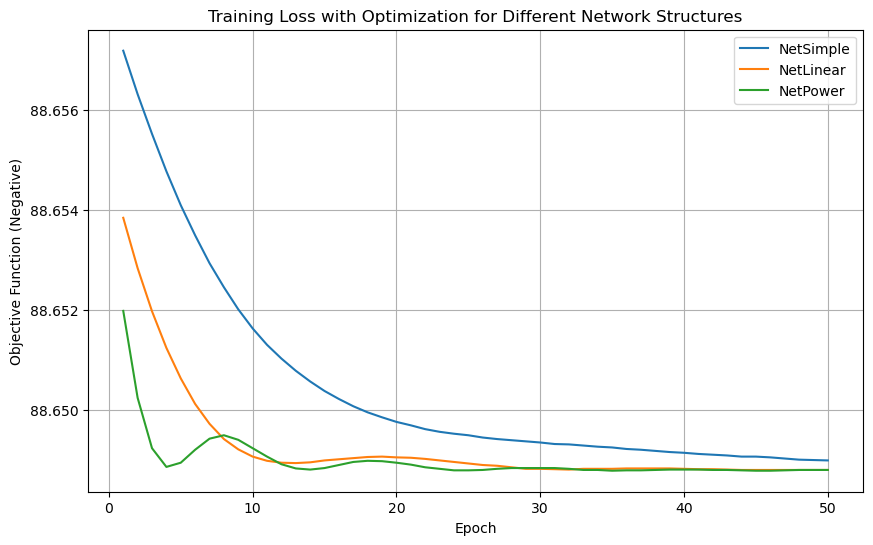

In [33]:
# obj func
def compute_objective(Q_n, J_n, f_n, gamma, beta, lambda_value, sigma):
    term1 = Q_n * f_n  # gross return
    term2 = gamma * sigma**2 * tf.square(Q_n)  # risk cost
    term3 = lambda_value * beta * tf.square(J_n)  # impact cost
    return tf.reduce_mean(term1 - term2 - term3)

# update K func
def kernel_matrix(timestamps, beta):
    time_diff = tf.expand_dims(timestamps, axis=1) - tf.expand_dims(timestamps, axis=0)
    kernel = tf.exp(-beta * tf.clip_by_value(time_diff, clip_value_min=0, clip_value_max=np.inf))
    return tf.linalg.band_part(kernel, 0, -1)

# update J_t function
def compute_J_t(signed_volume, kernel):
    signed_volume = tf.expand_dims(signed_volume, axis=1)
    J_t = tf.matmul(kernel, signed_volume)
    return tf.squeeze(J_t, axis=1)

# train function
def train_network_with_optimization(model, X, signed_volume, f_n, timestamps, beta, gamma, lambda_value, sigma, epochs):
    training_losses = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            # forward tran
            predicted_Q_n = model(X, training=True)
            kernel = kernel_matrix(timestamps, beta)
            J_n = compute_J_t(signed_volume, kernel)

            # loss
            loss = -compute_objective(predicted_Q_n, J_n, f_n, gamma, beta, lambda_value, sigma)

        # gradients
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        training_losses.append(loss.numpy())

    return training_losses

# nw model
def build_model(layers):
    model = Sequential()
    for units in layers[:-1]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(layers[-1], activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

timestamps = tf.convert_to_tensor(np.arange(len(data)), dtype=tf.float32)
signed_volume = tf.convert_to_tensor(data['Signed Volume'].values, dtype=tf.float32)
mid_price = tf.convert_to_tensor(data['mid_price'].values, dtype=tf.float32)
f_n = (mid_price[1:] / mid_price[:-1] - 1)

signed_volume = (signed_volume - tf.reduce_mean(signed_volume)) / tf.math.reduce_std(signed_volume)
f_n = (f_n - tf.reduce_mean(f_n)) / tf.math.reduce_std(f_n)

min_len = min(len(signed_volume), len(f_n), len(timestamps))
signed_volume = signed_volume[:min_len]
f_n = f_n[:min_len]
timestamps = timestamps[:min_len]

#char matrix
X = tf.stack([signed_volume, f_n], axis=1)

# parameters
beta = 0.05
gamma = 0.1
lambda_value = 0.02
sigma = 1.0
epochs = 50

#network models
networks = {
    "NetSimple": [32, 16, 1],
    "NetLinear": [64, 32, 1],
    "NetPower": [128, 64, 1],
}

training_results = {}

for name, layers in networks.items():
    model = build_model(layers)
    losses = train_network_with_optimization(
        model, X, signed_volume, f_n, timestamps, beta, gamma, lambda_value, sigma, epochs
    )
    training_results[name] = losses

# plot results
plt.figure(figsize=(10, 6))
for name, losses in training_results.items():
    plt.plot(range(1, epochs + 1), losses, label=name)
plt.title("Training Loss with Optimization for Different Network Structures")
plt.xlabel("Epoch")
plt.ylabel("Objective Function (Negative)")
plt.legend()
plt.grid()
plt.show()